# 転倒検出のための２クラスデータを取り出す
2024.10.10
UR Fall Detection Dataset
http://fenix.ur.edu.pl/~mkepski/ds/uf.html
から取得したデータを元手にして、「転倒前」「転倒後」の RGB 画像に切り分ける

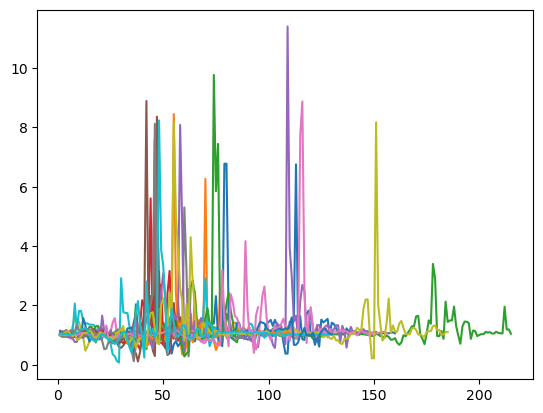

In [13]:
import csv
import matplotlib.pyplot as plt

import os
import shutil
try:
    os.makedirs("train/normal")
    os.makedirs("train/fall")
    os.makedirs("test/normal")
    os.makedirs("test/fall")
except:
    pass
    
# path = "/home/muto/Downloads/fall-01-acc.csv"

import numpy as np

'''
時系列データにおいて、閾値を超えるタイミング／閾値を下回るタイミングを取得する
(2024.10.09, Claude に教えてもらったコード)
'''
def detect_threshold_crossings(data, threshold):
    # 閾値を超えているかどうかのブール配列を作成
    above_threshold = data > threshold
    
    # 閾値を超えた瞬間と閾値を下回った瞬間を検出
    crossings = np.diff(above_threshold.astype(int))
    
    # 閾値を超えた瞬間のインデックスを取得
    rising_edges = np.where(crossings == 1)[0]
    
    # 閾値を下回った瞬間のインデックスを取得
    falling_edges = np.where(crossings == -1)[0]
    
    return rising_edges, falling_edges

'''
accelator の時系列データを利用して「転倒前までのタイミング」と
「転倒後のタイミング」を検出する
(メモ) *-data.csv を参照するから、リスト time は不要
(メモ) *-acc.csv は使わない
'''
def get_rising_falling_timing(time, data):
    data = np.array(data)
    threshold = 1.5 # !!!!! 適当な決め打ち
    
    # 閾値を超えるタイミングを検出
    rising_edges, falling_edges = detect_threshold_crossings(data, threshold)
    ### print(rising_edges)
    ### print(falling_edges)
    
    # 閾値 2.0 の場合、rising / falling とも、1箇所しか見つからないはず
    # print("rising:", rising_edges)
    # print("falling:", falling_edges)

    '''
    if len(rising_edges) > 0 and len(falling_edges) > 0:
        print("rising:", rising_edges[0])
        print("falliing:", falling_edges[-1])
        print("----------")
    '''

    # 立ち上がりの最初 ＆ 立ち下がりの最後を返す
    return rising_edges[0], falling_edges[-1]

'''
*-data.csv を参照し、「転倒直前のフレーム番号」と「転倒直後のフレーム番号」を入手
'''
def get_data(data_path):
    frames = []
    data = []
    with open(data_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            # print(row)
            frames.append(int(row[0]))
            # v = float(row[1])
            data.append(float(row[2]))

    rising, falling = get_rising_falling_timing(frames, data)

    plt.plot(frames, data)

    return rising, falling

# データセットの置き場所
parent_path = "/home/muto/Downloads/"

for idx in range(1, 11):
    # 転倒直前と転倒直後のフレーム番号を取得する
    data_path = "{}fall-{:0>2}-data.csv".format(parent_path, idx)
    # print(path)
    rising, falling = get_data(data_path)

    # RGB ファイルへのパスを取得
    rgb_dirname = "{}fall-{:0>2}-cam0-rgb".format(parent_path, idx)

    import glob
    rgb_paths = glob.glob(rgb_dirname + "/*.png")

    for rgb_path in rgb_paths:
        #### print(rgb_path)
        # fall-01-cam0-rgb-108.png の108 の部分を取り出す
        rgb_number = rgb_path.split('/')[-1].split('.')[0].split('-')[-1]
        rgb_number = int(rgb_number)

        # 転倒直前および転倒直後の RGB ファイルをそれぞれ normal / fall ディレクトリへコピー
        # → ディープラーニングモデルへ渡す
        if rgb_number <= rising: # 通常状態
            # print("normal: {}".format(rgb_path))
            shutil.copy2(rgb_path, 'train/normal')
        elif rgb_number >= falling: # 倒れている
            # print("fall: {}".format(rgb_path))
            shutil.copy2(rgb_path, 'train/fall')

for idx in range(11, 21):
    # 転倒直前と転倒直後のフレーム番号を取得する
    data_path = "{}fall-{:0>2}-data.csv".format(parent_path, idx)
    # print(path)
    rising, falling = get_data(data_path)

    # RGB ファイルへのパスを取得
    rgb_dirname = "{}fall-{:0>2}-cam0-rgb".format(parent_path, idx)

    import glob
    rgb_paths = glob.glob(rgb_dirname + "/*.png")

    for rgb_path in rgb_paths:
        #### print(rgb_path)
        # fall-01-cam0-rgb-108.png の108 の部分を取り出す
        rgb_number = rgb_path.split('/')[-1].split('.')[0].split('-')[-1]
        rgb_number = int(rgb_number)

        # 転倒直前および転倒直後の RGB ファイルをそれぞれ normal / fall ディレクトリへコピー
        # → ディープラーニングモデルへ渡す
        if rgb_number <= rising: # 通常状態
            # print("normal: {}".format(rgb_path))
            shutil.copy2(rgb_path, 'test/normal')
        elif rgb_number >= falling: # 倒れている
            # print("fall: {}".format(rgb_path))
            shutil.copy2(rgb_path, 'test/fall')


# 画像分類を行うコード

Classes: ['normal', 'fall']
Number of training images: 714
Number of test images: 657
Finished Training
Accuracy of the network on the test images: 88.89%


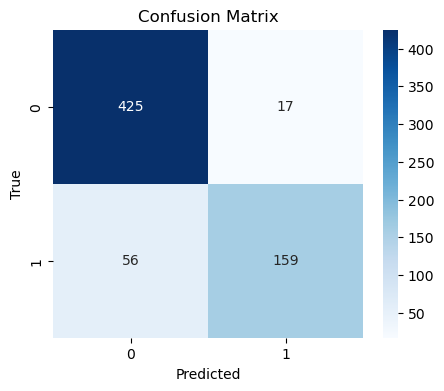

Accuracy of normal: 0.96
Accuracy of fall: 0.74

Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.96      0.92       442
        fall       0.90      0.74      0.81       215

    accuracy                           0.89       657
   macro avg       0.89      0.85      0.87       657
weighted avg       0.89      0.89      0.89       657



In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# カスタムデータセットクラスの定義
class FallDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['normal', 'fall']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# データセットのディレクトリ設定
#### data_dir = './data'  # このディレクトリを実際のデータセットのパスに変更してください
data_dir = '.'  # このディレクトリを実際のデータセットのパスに変更してください
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# データセットとDataLoaderの作成
train_dataset = FallDetectionDataset(train_dir, transform=transform)
test_dataset = FallDetectionDataset(test_dir, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

classes = train_dataset.classes
print(f"Classes: {classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

# CNNモデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

# 損失関数と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# トレーニング
for epoch in range(10):  # 10エポック分ループ
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # 100ミニバッチごとに出力
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

# テストデータでの評価
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# Confusion Matrix の計算
cm = confusion_matrix(all_labels, all_predictions)

# Confusion Matrix の表示
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# クラスごとの精度を計算
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracy):
    print(f'Accuracy of {classes[i]}: {accuracy:.2f}')

# Precision, Recall, F1-score の計算と表示
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=classes))

# この下は捨てるコード

閾値を超えたタイミング: [  9 109 140 142 207 307 407 507 541 607 610 639 706 805 904 940]
閾値を下回ったタイミング: [ 42 138 141 143 240 342 440 540 543 609 638 640 741 839 939 941]


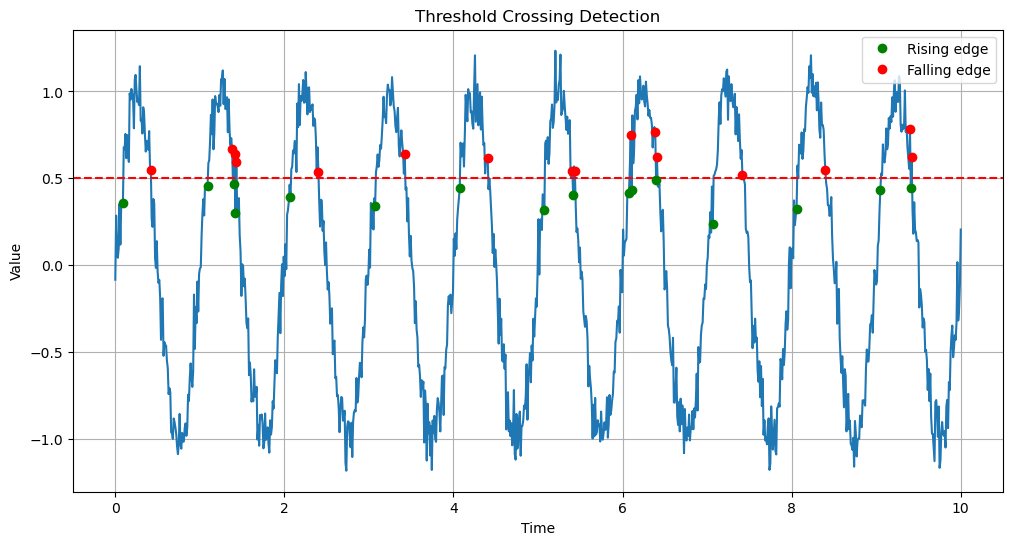

In [8]:
# (2024.10.09, Claude に教えてもらったコード)
import numpy as np

def detect_threshold_crossings(data, threshold):
    # 閾値を超えているかどうかのブール配列を作成
    above_threshold = data > threshold
    
    # 閾値を超えた瞬間と閾値を下回った瞬間を検出
    crossings = np.diff(above_threshold.astype(int))
    
    # 閾値を超えた瞬間のインデックスを取得
    rising_edges = np.where(crossings == 1)[0]
    
    # 閾値を下回った瞬間のインデックスを取得
    falling_edges = np.where(crossings == -1)[0]
    
    return rising_edges, falling_edges

# テストデータの作成
time = np.linspace(0, 10, 1000)
data = np.sin(2 * np.pi * time) + np.random.normal(0, 0.1, time.shape)

# 閾値の設定
threshold = 0.5

# 閾値を超えるタイミングを検出
rising_edges, falling_edges = detect_threshold_crossings(data, threshold)

print("閾値を超えたタイミング:", rising_edges)
print("閾値を下回ったタイミング:", falling_edges)

# 結果のプロット（オプション）
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, data)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.plot(time[rising_edges], data[rising_edges], 'go', label='Rising edge')
plt.plot(time[falling_edges], data[falling_edges], 'ro', label='Falling edge')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Threshold Crossing Detection')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import numpy as np

data = np.array(data)
threshold = 1.5

# 閾値を超えるタイミングを検出
rising_edges, falling_edges = detect_threshold_crossings(data, threshold)

# 閾値 2.0 の場合、rising / falling とも、1箇所しか見つからないはず
print("rising:", rising_edges)
print("falling:", falling_edges)

print("rising:", time[rising_edges[0]])
print("falliing:", time[falling_edges[-1]])


rising: [114 117 119 130 136 139 149 152]
falling: [115 118 121 134 137 143 150 153]
rising: 3246
falliing: 4244


In [11]:
falling_edges

array([], dtype=int64)

In [ ]:
98, 129